In [1]:
appId = "app-20170515173053-0032"
filepath = "/home/ec2-user/spark/work/%s/*/stdout" % appId
servers = """ec2-54-242-174-134.compute-1.amazonaws.com
ec2-34-201-221-92.compute-1.amazonaws.com
ec2-54-147-195-205.compute-1.amazonaws.com
ec2-52-205-192-85.compute-1.amazonaws.com
ec2-54-174-109-151.compute-1.amazonaws.com
ec2-54-164-5-214.compute-1.amazonaws.com
ec2-34-207-175-53.compute-1.amazonaws.com
ec2-54-162-54-78.compute-1.amazonaws.com
ec2-52-55-35-52.compute-1.amazonaws.com
ec2-184-73-47-139.compute-1.amazonaws.com""".split('\n')

In [2]:
import os
'''
for server in servers:
    os.system("scp %s:%s ~/logs/%s" % (server, filepath, server))
'''

'\nfor server in servers:\n    os.system("scp %s:%s ~/logs/%s" % (server, filepath, server))\n'

In [ ]:
from os import listdir

def process(s):
    res = s.strip()[1:-1].split(',')
    return [int(res[0]), int(res[1]), int(res[2]), int(res[3]), float(res[4]), res[5] == "true", res[6] == "true"]


dirpath = "/home/ec2-user/logs/"
logs = [f for f in listdir(dirpath)]
tuples = []
for log in logs:
    log = dirpath + log
    tuples += map(process, open(log).readlines())

In [20]:
sorted_tuples = sorted(tuples)
len(sorted_tuples)

72254528

In [49]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data=sorted_tuples,
                  columns=["partition", "rule", "sampleId", "y", "w", "predict", "stopped"])

In [24]:
%matplotlib inline

from operator import itemgetter
from matplotlib import pyplot as plt
from math import log

def vis(glomId, T=300, showBound=False):
    data = {}
    lastSample = {}
    score = {}
    for _glomId, ruleId, t, y, w, predict, stop in sorted_tuples:
        if _glomId == glomId:
            if ruleId not in data:
                data[ruleId] = []
                lastSample[ruleId] = -1
                score[ruleId] = 0.0
            # t, y, w, score, predict, sto
            if t != lastSample[ruleId] and t < T:
                assert(t == lastSample[ruleId] + 1)
                lastSample[ruleId] = t
                if predict:
                    score[ruleId] += y * w
                data[ruleId].append(
                    (t, score[ruleId])
                )
    plt.figure(figsize=(15, 5))
    for dkey in data:
        d = data[dkey]
        plt.plot(map(itemgetter(0), d), map(itemgetter(1), d), label=str(dkey))
    
    if showBound:
        bound = []
        for i in range(T):
            bound.append(wald(gamma, delta, i))
        plt.plot(bound)
        plt.plot(list(map(lambda t: -t, bound)))
    return data

In [48]:
%matplotlib inline

from operator import itemgetter
from matplotlib import pyplot as plt
from math import log

def getData():
    data = {}
    lastSample = {}
    score = {}
    for glomId, ruleId, t, y, w, predict, stop in sorted_tuples:
        key = (glomId, ruleId)
        if key not in data:
            data[key] = []
            lastSample[key] = -1
            score[key] = 0.0
        # t, y, w, score, predict, sto
        if t != lastSample[key]:
            assert(t == lastSample[key] + 1)
            lastSample[key] = t
            if predict:
                score[key] += y * w
            data[key].append(
                (t, score[key])
            )
    return data

In [49]:
# data = vis(1, T=30000, showBound=True)
data = getData()

In [39]:
gloms = set(map(itemgetter(0), sorted_tuples))
print gloms

set([0, 1, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 54, 55, 56, 58, 59, 60, 61, 64, 65, 66, 68, 69, 70, 71, 74, 75, 76, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130])


In [52]:
from math import log
from math import sqrt

def wald(gamma, delta, wsum):
    rou = log((0.5 + 2 * gamma) * (0.5 - gamma) / (0.5 - 2 * gamma) / (0.5 + gamma))
    alpha = 1.0 / rou * log((1.0 - delta) / delta)
    beta = 1.0 / rou * log((0.5 - gamma) / (0.5 - 2 * gamma))
    return 2 * alpha + (2 * beta - 1) * wsum

def br(gamma, delta, wsum):
    kbr = 1
    n = max(10.0, wsum)
    return sqrt(kbr * n * log(log(n) / delta)) + 2 * n * gamma

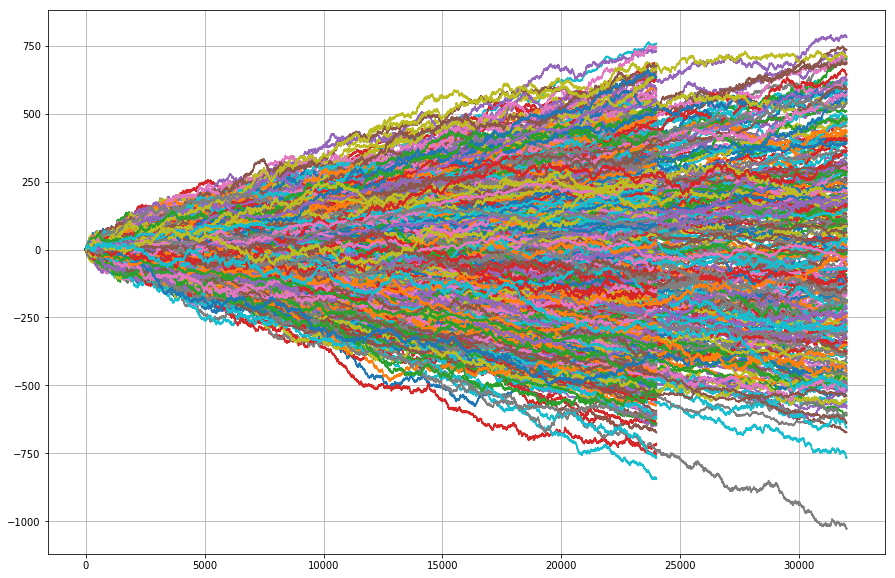

In [51]:
import numpy as np

T = 30000

fig, ax = plt.subplots(figsize=(15, 10))
# plt.figure(figsize=(15, 10))
for dkey in data:
    d = data[dkey]
    ax.plot(map(itemgetter(0), d), map(itemgetter(1), d), label=str(dkey))
ax.grid()

In [61]:
gamma = 0.005
delta = pow(10, -2)

bound1 = []
bound2 = []
for i in range(T):
    bound1.append(wald(gamma, delta, i))
for i in range(T):
    bound2.append(br(gamma, delta, i))
lines1 = ax.plot(bound1)
lines2 = ax.plot(bound2)

In [59]:
lines1.pop(0).remove()
lines2.pop(0).remove()

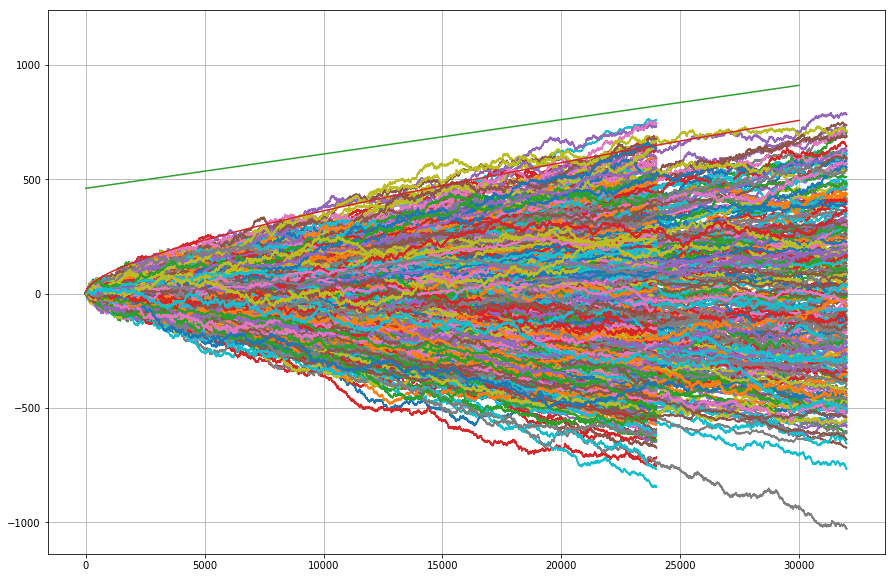

In [62]:
fig

In [ ]:
import pickle
# pickle.dump(tuples, open("/home/ec2-user/tuples.pkl", 'wb'))
pickle.dump(sorted(tuples), open("/home/ec2-user/sorted-tuples.pkl", 'wb'))